# 📘 M2C2 DataKit Notebook: Universal Loading, Assurance, and Scoring

This notebook demonstrates a full analytic pipeline using the `m2c2-datakit` package. It uses the `LASSIE` class to load, validate, score, and optionally export data from multiple source types.

---

## 🎯 Purpose

Enable researchers to plug in data from varied sources (e.g., MongoDB, UAS, MetricWire, CSV bundles) and apply a consistent pipeline for:

- Input validation

- Scoring via predefined rules

- Inspection and summarization

- Tidy export and codebook generation

---

## Inspired by:

<img src="https://m.media-amazon.com/images/M/MV5BNDNkZDk0ODktYjc0My00MzY4LWE3NzgtNjU5NmMzZDA3YTA1XkEyXkFqcGc@._V1_FMjpg_UX1000_.jpg" alt="Inspiration for Package, Lassie Movie" width="100"/>

## 🧠 L.A.S.S.I.E. Pipeline Summary

| Step | Method           | Purpose                                                                 |
|------|------------------|-------------------------------------------------------------------------|
| L    | `load()`         | Load raw data from a supported source (e.g., MongoDB, UAS, MetricWire). |
| A    | `assure()`       | Validate that required columns exist before processing.                 |
| S    | `score()`        | Apply scoring logic based on predefined or custom rules.                |
| S    | `summarize()`    | Aggregate scored data by participant, session, or custom groups.        |
| I    | `inspect()`      | Visualize distributions or pairwise plots for quality checks.           |
| E    | `export()`       | Save scored and summarized data to tidy files and optionally metadata.  |

---


## 📦 Supported Sources

You may have used M2C2kit tasks via our various integrations, including the ones listed below. Each integration has its own loader class, which is responsible for reading the data and converting it into a format that can be processed by the `m2c2_datakit` package. Keep in mind that you are responsible for ensuring that the data is in the correct format for each loader class.

In the future we anticipate creating loaders for downloading data via API.

| Source Type   | Loader Class          | Key Arguments                            | Notes                                 |
|---------------|------------------------|-------------------------------------------|----------------------------------------|
| `mongodb`     | `MongoDBImporter`      | `source_path` (URL, to JSON)                      | Expects flat or nested JSON documents. |
| `multicsv`    | `MultiCSVImporter`     | `source_map` (dict of CSV paths)          | Each activity type is its own file.    |
| `metricwire`  | `MetricWireImporter`   | `source_path` (glob pattern or default)   | Processes JSON files from unzipped export. |
| `qualtrics`    | `QualtricsImporter`     | `source_path` (URL to CSV)         | Each activity's trial saves data to a new column.    |
| `uas`         | `UASImporter`          | `source_path` (URL, to pseudo-JSON)                       | Parses newline-delimited JSON.         |


---

## 🚀 Example Pipeline Steps

### Step 1: Load Data

```python
source_map = {
    "Symbol Search": "data/reboot/m2c2kit_manualmerge_symbol_search_all_ts-20250402_151939.csv",
    "Grid Memory": "data/reboot/m2c2kit_manualmerge_grid_memory_all_ts-20250402_151940.csv"
}

mcsv = m2c2.core.pipeline.LASSIE().load(source_name="multicsv", source_map=source_map)
mw = m2c2.core.pipeline.LASSIE().load(source_name="metricwire", source_path="data/metricwire/unzipped/*/*/*.json")
mdb = m2c2.core.pipeline.LASSIE().load(source_name="mongodb", source_path="data/production-mongo-export/data_exported_120424_1010am.json")
uas = m2c2.core.pipeline.LASSIE().load(source_name="UAS", source_path= "https://uas.usc.edu/survey/uas/m2c2_ess/admin/export_m2c2.php?k=<INSERT KEY HERE>")
```

---

### Step 2: Verify Data

```python
mcsv.assure(required_columns=m2c2.core.config.settings.STANDARD_GROUPING_FOR_AGGREGATION)
mw.assure(required_columns=m2c2.core.config.settings.STANDARD_GROUPING_FOR_AGGREGATION_METRICWIRE)
mdb.assure(required_columns=m2c2.core.config.settings.STANDARD_GROUPING_FOR_AGGREGATION)
uas.assure(required_columns=m2c2.core.config.settings.STANDARD_GROUPING_FOR_AGGREGATION)
```
---

### Step 3: Score Data

```python
mcsv.score()
mw.score()
mdb.score()
uas.score()
```

### Step 4: Inspect Data

```python
mcsv.inspect()
mw.inspect()
mdb.inspect()
uas.inspect()
```
---

### Step 5: Summarize Data

```python
mcsv.summarize(grouping=m2c2.core.config.settings.STANDARD_GROUPING_FOR_AGGREGATION)
mw.summarize(grouping=m2c2.core.config.settings.STANDARD_GROUPING_FOR_AGGREGATION_METRICWIRE)
mdb.summarize(grouping=m2c2.core.config.settings.STANDARD_GROUPING_FOR_AGGREGATION)
uas.summarize(grouping=m2c2.core.config.settings.STANDARD_GROUPING_FOR_AGGREGATION)
```

---

### Step 6: Export Data

```python
output_folder = "tidy
mcsv.export(file_basename="uas_export", directory=output_folder)
mw.export(file_basename="metricwire", directory=output_folder)
mdb.export(file_basename="mongodb_export", directory=output_folder)
uas.export(file_basename="uas_export", directory=output_folder)

```

#### Oh yeah, and export the codebook too!

```python
mcsv.export_codebook(filename="codebook_uas.md", directory=output_folder)
mw.export_codebook(filename="codebook_metricwire.md", directory=output_folder)
mdb.export_codebook(filename="codebook_mongo.md", directory=output_folder)
uas.export_codebook(filename="codebook_uas.md", directory=output_folder)
```

## Verify Data

## 🛠️ Setup for Developers of this Package

## Setup Environment to run Notebook

This section is for developer use only. Ignore the two code chunks below if you are a user of the package..

In [ ]:
!make dev-install

In [ ]:
!uv pip show m2c2_datakit


In [1]:
import sys
!{sys.executable} -m pip install --upgrade m2c2_datakit


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python3.10 -m pip install --upgrade pip


In [2]:
import os
import re
import glob
import json
from dotenv import load_dotenv
import m2c2_datakit as m2c2
m2c2.core.get_package_version()

'0.1.88'

## Configure output folder and summary functions

In [3]:
output_folder = "tidy"

summary_func_map = {
    "Symbol Search": m2c2.tasks.symbol_search.summarize,
    "Grid Memory": m2c2.tasks.grid_memory.summarize,
    
    "symbol-search": m2c2.tasks.symbol_search.summarize,
    "grid-memory": m2c2.tasks.grid_memory.summarize,
}

# ^ this also means that a user could specify their own summarize functions as needed!

## Step 1: Load Data

In [4]:
# Define source_folder relative to current working directory
#source_folder_mw = os.path.abspath(os.path.join(os.pardir, 'datakit/data/metricwire/unzipped'))
#source_path_mw = f"{source_folder_mw}/*/*/*.json"

#source_folder_mdb = os.path.abspath(os.path.join(os.pardir, "datakit/data/production-mongo-export"))
#source_path_mdb = f"{source_folder_mdb}/data_exported_120424_1010am.json"

source_folder_qualtrics = os.path.abspath(os.path.join(os.pardir, "datakit/data/qualtrics"))
source_path_qualtrics = f"{source_folder_qualtrics}/M2C2 2 Task_May 2, 2025_10.37.csv"

# Data from REBOOT Study (UCF and PSU) was manually merged so we have two csvs to load
source_map = {
    "Symbol Search": "~/Documents/GitHub/datakit/data/reboot/m2c2kit_manualmerge_symbol_search_all_ts-20250402_151939.csv",
    "Grid Memory": "~/Documents/GitHub/datakit/data/reboot/m2c2kit_manualmerge_grid_memory_all_ts-20250402_151940.csv"
}

# Data from Metricwire
#mw = m2c2.core.pipeline.LASSIE().load(source_name="metricwire", source_path=source_path_mw)

# Data from demo M2C2 study on PSU production server
#mdb = m2c2.core.pipeline.LASSIE().load(source_name="mongodb", source_path=source_path_mdb)

# Data from REBOOT Study (UCF and PSU) was manually merged so we have two csvs to load
#mcsv = m2c2.core.pipeline.LASSIE().load(source_name="multicsv", source_map=source_map)

# Data from Qualtrics
qualtrics = m2c2.core.pipeline.LASSIE().load(source_name="qualtrics", source_path=source_path_qualtrics)

# Data from UAS
#load_dotenv()
#UAS_LATEST_KEY = os.getenv("UAS_LATEST_KEY")
#uas = m2c2.core.pipeline.LASSIE().load(source_name="UAS", source_path= f"https://uas.usc.edu/survey/uas/m2c2_ess/admin/export_m2c2.php?k={UAS_LATEST_KEY}")

/var/folders/s5/cdfgl21s67g7kcj9ts4x8pnn4njnsy/T/ipykernel_32761/1650587346.py:27: LogfireNotConfiguredWarning: No logs or spans will be created until `logfire.configure()` has been called. Set the environment variable LOGFIRE_IGNORE_NO_CONFIG=1 or add ignore_no_config=true in pyproject.toml to suppress this warning.
  qualtrics = m2c2.core.pipeline.LASSIE().load(source_name="qualtrics", source_path=source_path_qualtrics)


## Step 2: Verify Data

In [5]:
#mdb.assure(required_columns=m2c2.core.config.settings.STANDARD_GROUPING_FOR_AGGREGATION)
#mcsv.assure(required_columns=['participant_id'])
#mw.assure(required_columns=m2c2.core.config.settings.STANDARD_GROUPING_FOR_AGGREGATION_METRICWIRE)
qualtrics.assure(required_columns=['ResponseId'])
#uas.assure(required_columns=m2c2.core.config.settings.STANDARD_GROUPING_FOR_AGGREGATION)

## Step 3: Score Data

In [6]:
#mdb.score()
#mcsv.score()
#mw = mw.score()
qualtrics.score()
#uas.score()

## Step 4: Summarize Data

In [7]:
#mdb.summarize(summary_func_map = summary_func_map)
#mcsv.summarize(summary_func_map = summary_func_map)
#mw.summarize(summary_func_map = summary_func_map)
qualtrics.summarize(summary_func_map = summary_func_map, groupby_cols=['ResponseId'])
#uas.summarize(summary_func_map = summary_func_map)

## Step 5: Inspect Data (plots)

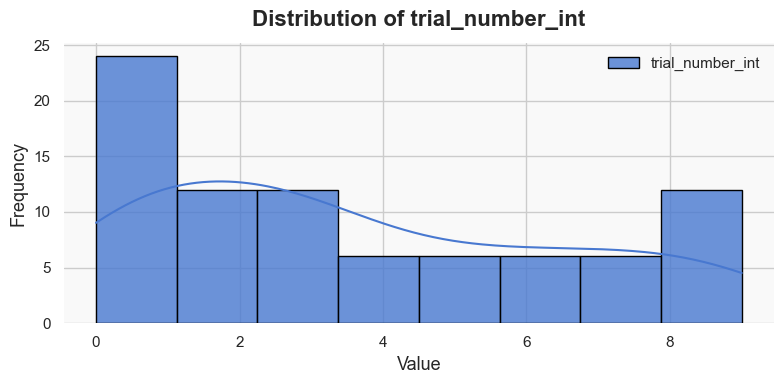

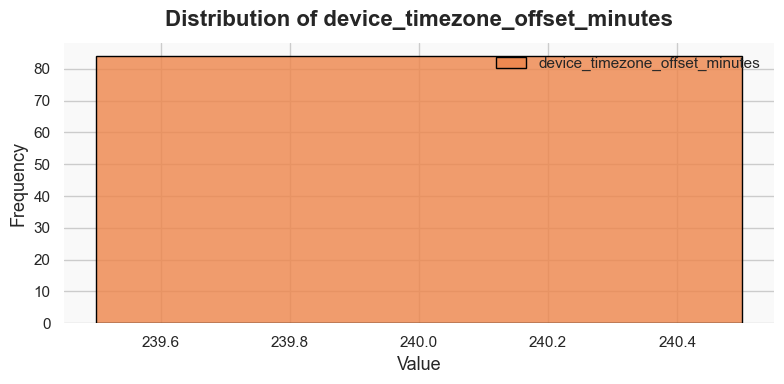

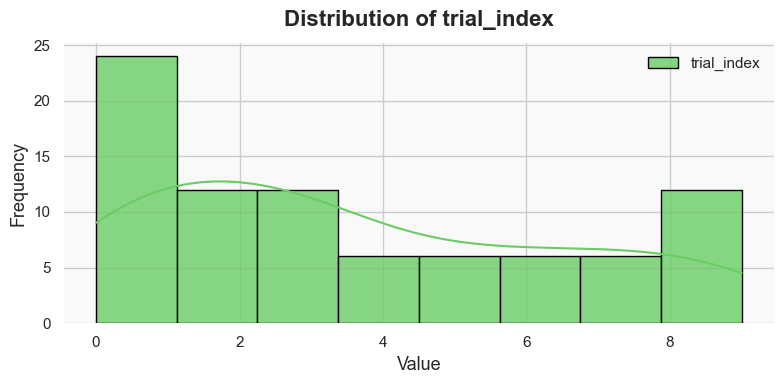

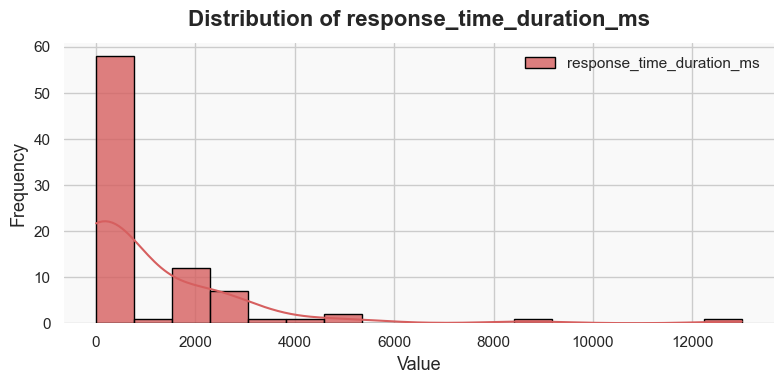

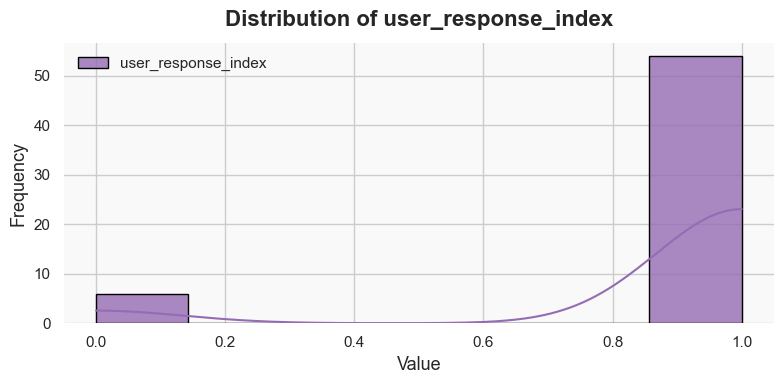

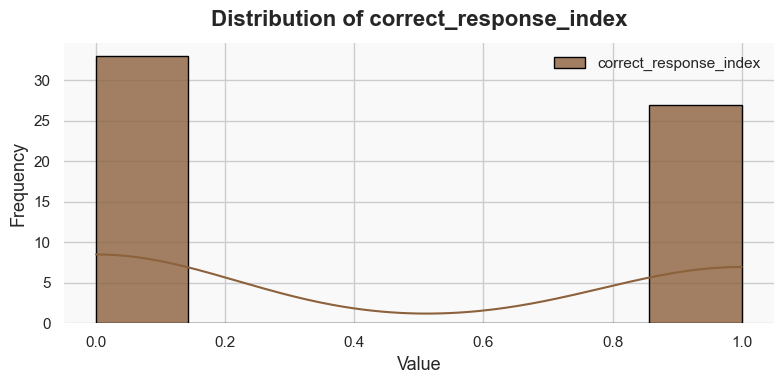

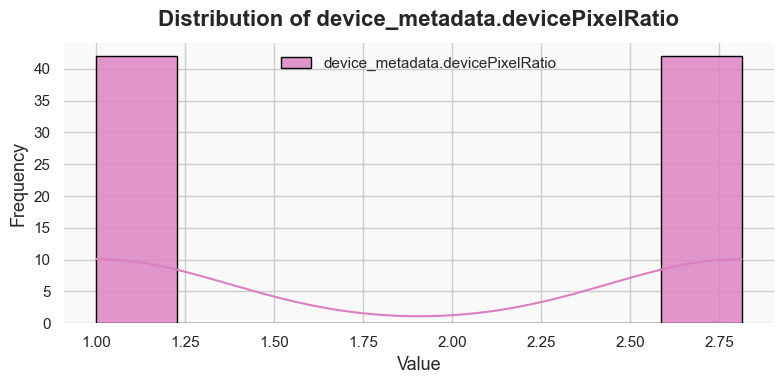

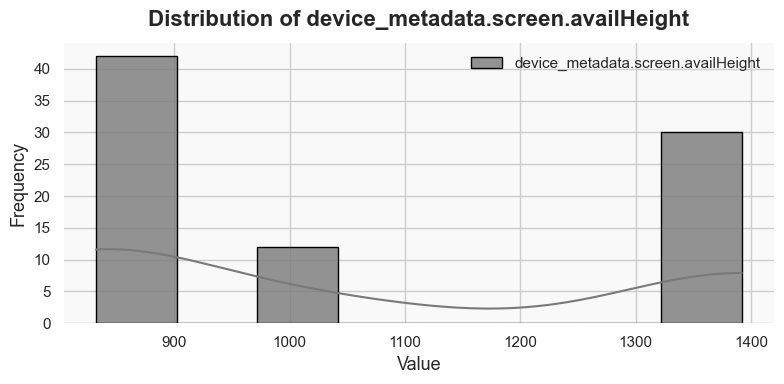

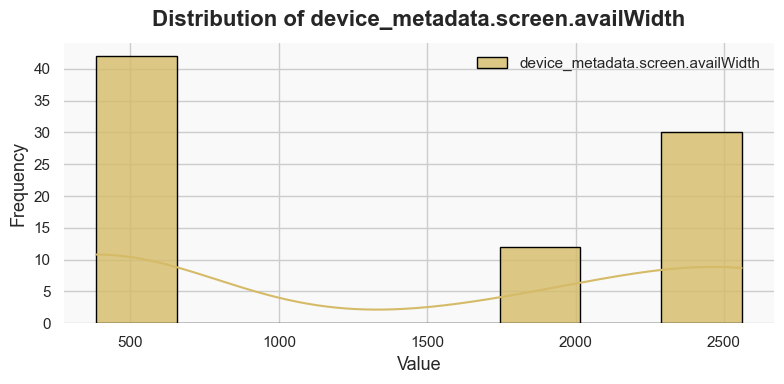

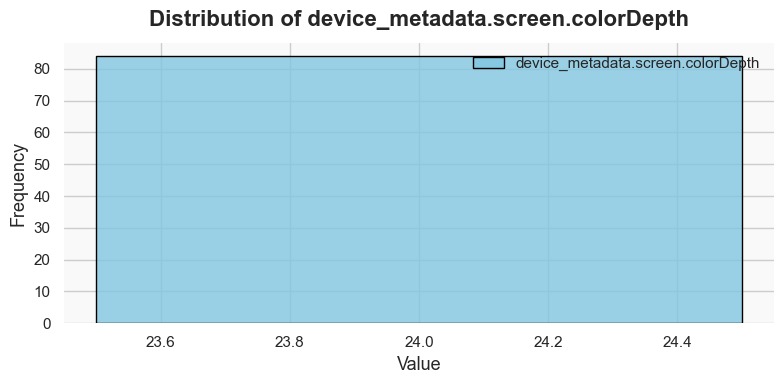

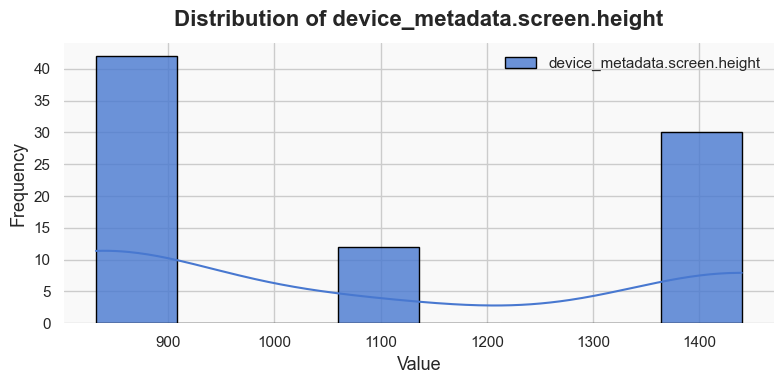

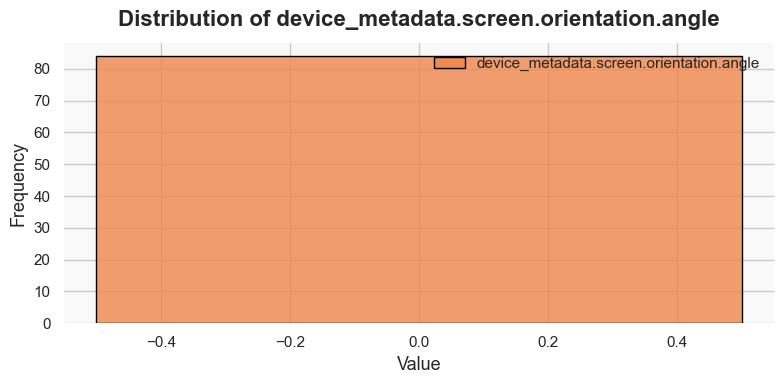

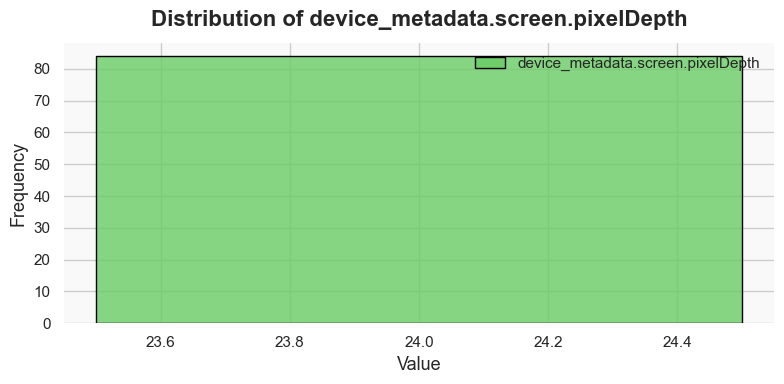

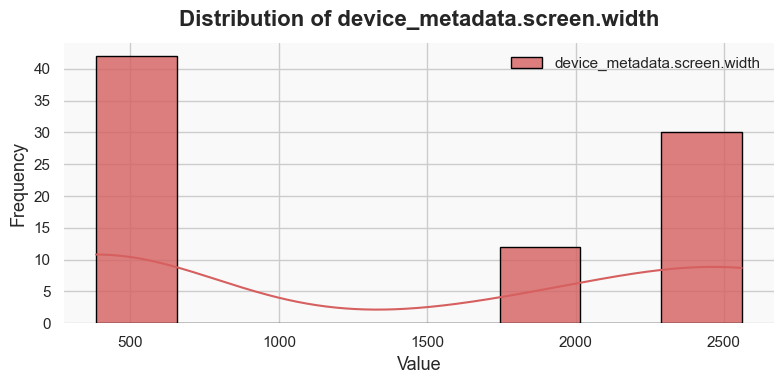

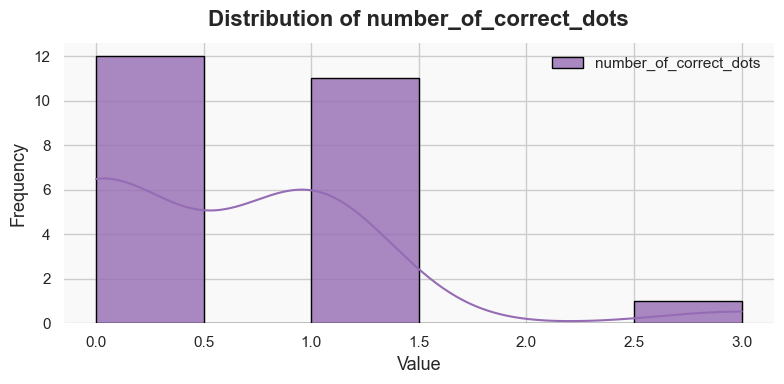

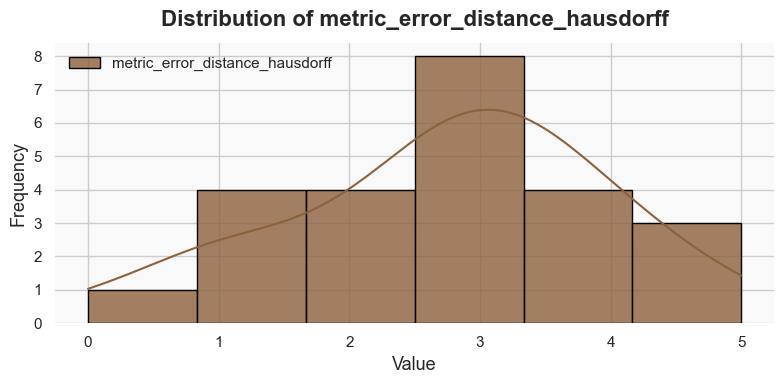

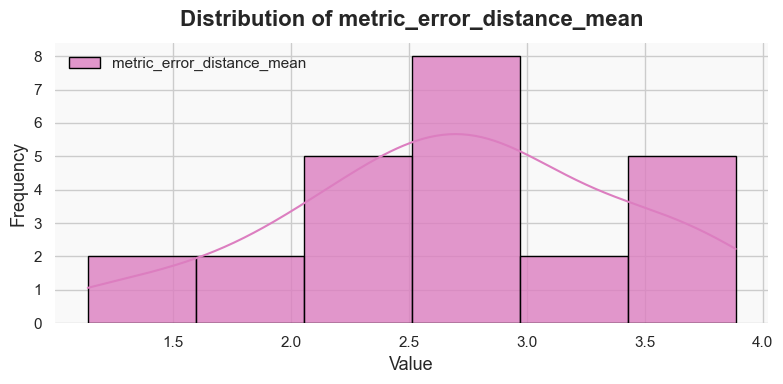

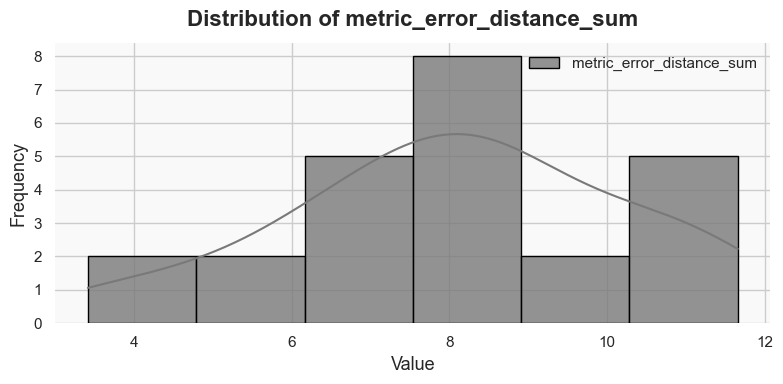

In [8]:
#mdb.inspect()
#mcsv.inspect()
#mw.inspect()
qualtrics.inspect()
#uas.inspect()

## Step 6: Export Data and Codebooks

In [ ]:
#mdb.export(file_basename="MDB", directory="tidy", formats=[".xlsx", ".Rdata"])

In [9]:
# mw.export(file_basename="export_metricwire", directory=output_folder)
# mw.export_codebook(filename="codebook_metricwire.md", directory=output_folder)

# mdb.export(file_basename="export_mongodb", directory=output_folder)
# mdb.export_codebook(filename="codebook_mongo.md", directory=output_folder)

# mcsv.export(file_basename="export_multicsv", directory=output_folder)
# mcsv.export_codebook(filename="codebook_multicsv.md", directory=output_folder)

#uas.export(file_basename="export_uas", directory=output_folder)
#uas.export_codebook(filename="codebook_uas.md", directory=output_folder)

qualtrics.export(file_basename="export_qualtrics", directory=output_folder)
qualtrics.export_codebook(filename="codebook_qualtrics.md", directory=output_folder)

[EXPORT] DataFrame successfully exported to: tidy/export_qualtrics_scored.csv
[EXPORT] DataFrame successfully exported to: tidy/export_qualtrics_summary_Grid Memory.csv
[EXPORT] DataFrame successfully exported to: tidy/export_qualtrics_summary_Symbol Search.csv
Metadata saved to tidy/export_qualtrics_metadata.json


## Step 7: See What's Inside

In [11]:
#mdb.whats_inside()
#mcsv.whats_inside()
#mw.whats_inside()
#qualtrics.whats_inside()
#uas.whats_inside()